The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-alpha0

# 9.1. Gated Recurrent Units (GRU)

지난 섹션에서 RNN에서 gradients가 어떤 식으로 계산되는가 같이 알아보았다.
Simple RNN에서는 tensor가 길게 곱해지면 gradients가 폭발하거나 소실해버리는 문제가 발생할 수 있는데, gradients가 이렇게 비정상적으로 계산되는 것은 실제로 다음과 같은 문제를 일으킬 수 있다.

* 미래 어떤 시점의 값을 예측하는데 있어 초기의 관측치가 매우 중요한 경우가 있을 수 있다. 예를 들어 첫 번째 관측치가 어떤 체크섬을 포함하고 있고, 모델의 목적이 시퀀스의 끝에서 이 체크섬이 정확한지 확인하는 것이다. 이런 경우 첫 번째 관측치의 영향력이 매우 중요하다. 만일 초기 관측치의 정보를 저장하는 어떤 메커니즘이 없다면 이 초기 관측치에 매우 큰 gradient를 할당해야 하는데 이 gradient가 이후의 모든 관측치에 영향을 끼친다.
* 일부의 토큰이 전체에 별다른 영향을 끼치지 않는 경우가 있을 수 있다. 예를 들어, 웹 페이지의 코드를 분석할 때 페이지에 전달되는 기능과는 무관한 보조 코드가 있을 수 있다. 잠재상태에서 이러한 토큰을 건너뛰는 어떤 메커니즘이 필요할 수 있다.
* 시퀀스 일부 사이에 논리적인 단절이 있는 상황에 직면할 수 있다.<br>
(ex) 책의 장들 사이의 전환, 증권을 위한 약세와 강세 시장 사이의 전환)<br>
이 경우 내부 상태를 표현할 수 있는 어떤 메커니즘이 필요할 수 있다.

이러한 문제들을 다루는 몇가지 기법들이 고안되어왔다.<br>
- LSTM(long short-term memory,장단기 메모리)[`Hochreiter&Schmidhuber.1997`]
- GRU(The gated recurrent unit,게이트 순환 유닛)[`Cho et al 2014a`] 

GRU의 경우 LSTM에 비해 약간 더 간소화된 변형으로 유사한 성능을 보이면서도 단순한 구조로 빠른 속도를 보여준다.

## 9.1.1. Gated Hidden State

가장 기본적인 형태의 RNN과 GRU의 가장 핵심적인 차이는 후자가 은닉(hidden) 상태의 게이트를 지원한다는 점이다. 즉 은닉 상태를 업데이트(update) 혹은 리셋(reset)하는 기능을 하는 메커니즘이다. 이러한 메커니즘은 학습에 의해 훈련되고 위에 나열된 문제들을 해결하게 된다. 가령 첫 번째 토큰이 다른 토큰에 비해 매우 중요한 경우 첫 번째 관찰 후 은닉 상태를 업데이트하지 않고 의미없는 관찰은 건너뛰는(skip) 방향으로 학습되는 것을 확인할 수 있다. 또 필요할 때마다 은닉 상태를 재설정하는 방법 역시 다루게 된다.

### 9.1.1.1. Reset Gate and Update Gate

첫 번째로 소개할 것은 reset gate와 update gate이다. 이름의 의미 그대로 어떤 시점의 관측치 $X_t$와 이전 시점의 은닉 상태 $H_{t-1}$에 대해 reset gate는 어느 정도를 기억할지 제어하고 update gate는 GRU 셀을 통해 계산될 새로운 상태(new state)가 이전 상태를 얼마나 포함하게 되는지 제어한다.
(covex한 조합이 되게 하기 위해 0~1 사이의 값들로 이뤄진 벡터가 되도록 설계한다.)

이 게이트들을 설계하는 것에서부터 시작한다. 아래 그림은 현재 시점의 입력 벡터(관측치, $X_t$)와 이전 시점의 은닉 상태($H_{t-1}$) 두 가지를 고려해 어떤 방식으로 게이트에 값이 입력되는지를 나타낸다. 두 게이트의 출력은 sigmoid를 activation으로 하는 fully-connected layer에 의해 생성된다.


![Computing the reset gate and the update gate in a GRU model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/gru-1.svg?raw=1)



$\mathbf{X}_t \in \mathbb{R}^{n \times d}$ (number of examples: $n$ (mini-batch size), number of inputs: $d$) <br> 
$\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$ (number of hidden units: $h$)<br>
$\mathbf{R}_t \in \mathbb{R}^{n \times h}$(reset gate)<br>
$\mathbf{Z}_t \in \mathbb{R}^{n \times h}$(update gate)

$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned}
$$

(weights)<br>
$\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h}$<br>
$\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$<br>

(bias)<br>
$\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$<br>
더해지는 동안 broadcasting이 수행되며 출력값을 0~1로 맞추기 위해 sigmoid 함수를 사용한다.

### 9.1.1.2. Candidate Hidden State

![Computing the candidate hidden state in a GRU model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/gru-2.svg?raw=1)

reset gate의 값 $\mathbf{R}_t$이 계산되었다면 다음과 같은 수식으로 candidate hidden state를 계산한다.


$\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$ at time step $t$:

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h),$$

(weights)<br>
$\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$ <br>
$\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$ <br>
(bias)<br>
$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$

($\odot$는 elementwise 곱의 연산기호)

candidate hidden state에는  -1~1의 값을 갖도록 비선형성을 tanh 형태의 비선형성을 사용한다.

이 결과값이 candidate인 것은 update gate의 역할과 합쳐질 것이 남아있기 때문이다. 현재 이전 상태의 영향은 $\mathbf{R}_t$와 $\mathbf{H}_{t-1}$의 elementwise 곱으로 일정 부분 제거되어있다. $\mathbf{R}_t$의 값들이 1에 가까울 수록 단순 RNN의 상태와 비슷해진다. $\mathbf{R}_t$의 값들이 0에 가까울 수록  candidate hidden state는 $X_t$를 입력으로 받는 MLP와 결과가 비슷해진다.


### 9.1.1.3 Hidden State

마지막으로 update gate $\mathbf{Z}_t$의 효과를 합쳐야한다. 이 $Z_t$의 값에 따라 새 은닉상태(hidden state)가 그저 이전 상태의 은닉 벡터($H_{t-1}$)를 그대로 받을 정도와 새 candidate hidden state가 얼마나 사용될지를 결정짓는다.

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t$$


만일 $\mathbf{Z}_t$가 1에 가까워진다면 이전 상태($H_{t-1}$)를 그대로 유지하게 된다. 이러한 경우 시점 t는 건너뛰어지며 $X_t$로부터 얻어지는 새 정보는 모두 무시된다. $\mathbf{Z}_t$가 0에 가까워진다면 새 은닉벡터 $H_t$는 candidate latent(hidden) state $\tilde{\mathbf{H}}_t$와 근접하게 된다.

이러한 설계는 RNN에서 소실되는 gradient 문제를 처리하고 시간 단계의 차이가 많이 존재하는 큰 시퀀스내의 영향도를 파악하는데 도움이 된다. 가령 update gate가 전체 기간 동안 1에 가까웠다면, 시작 단계의 한참 오래된 은닉 상태가 시퀀스 길이에 관계없이 종료 단계까지 전달된다.


![Computing the hidden state in a GRU model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/gru-3.svg?raw=1)
:label:`fig_gru_3`


In summary, GRU는 다음과 같은 구별되는 특징이 있다.

* Reset gates는 시퀀스의 단기 의존성의 특징을 잡도록 도와준다.
* Update gates는 시퀀스의 장기 의존성의 특징을 잡도록 도와준다.



## 9.1.2. Implementation from Scratch

To gain a better understanding of the GRU model, let's implement it from scratch.

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

### 9.1.2.1. (**Initializing Model Parameters**)

우선 표준편차를 0.01로 갖는 정규분포를 따르도록 모델 파라미터를 초기화한다. 하이퍼파라미터 num_hiddens는 은닉 유닛의 수를 정의한다. update gate, reset gate, candidate hidden state의 모든 가중치와 편향을 instance화한다.

In [ ]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state

### 9.1.2.2.  Defining the Model

GRU의forward propagation 계산을 정의한다.


In [ ]:
@d2l.add_to_class(GRUScratch)
def forward(self, inputs, H=None):
    matmul_H = lambda A, B: torch.matmul(A, B) if H is not None else 0
    outputs = []
    for X in inputs:
        Z = torch.sigmoid(torch.matmul(X, self.W_xz) + (
            torch.matmul(H, self.W_hz) if H is not None else 0) + self.b_z)
        if H is None: H = torch.zeros_like(Z)
        R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                        torch.matmul(H, self.W_hr) + self.b_r)
        H_tilda = torch.tanh(torch.matmul(X, self.W_xh) +
                           torch.matmul(R * H, self.W_hh) + self.b_h)
        H = Z * H + (1 - Z) * H_tilda
        outputs.append(H)
    return outputs, (H, )

### 9.1.2.3. Training

이전 장에서 사용한 언어모델과 동일하게 *The Time Machine* dataset을 이용해 학습을 진행하고 perplexity를 측정한다.


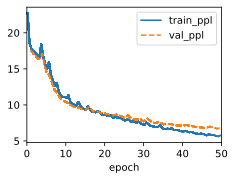

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## 9.1.3. [**Concise Implementation**]

조금더 High level한 API를 이용하면 간단하면서 빠르게 학습시킬 수 있다.


In [ ]:
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)

Python이 아닌 컴파일된 연산자를 사용하기 때문에 상당한 속도를 보여준다.


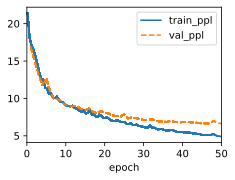

In [ ]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

훈련된 모델을 이용해 다음과 같이 문장 뒤에 이어질 내용을 예측해볼 수 있다.


In [ ]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has a can a canimat as '

## Summary

* Gated RNNs can better capture dependencies for sequences with large time step distances.
* Reset gates help capture short-term dependencies in sequences.
* Update gates help capture long-term dependencies in sequences.
* GRUs contain basic RNNs as their extreme case whenever the reset gate is switched on. They can also skip subsequences by turning on the update gate.



# 9.2.Long Short-Term Memory (LSTM)

LSTM은 모델의 장기 정보 보존과 단기 입력의 건너뛰에 관한 초기 접근 방식 중 하나이다. LSTM은 GRU보다 약간 더 복잡한 설계를 가지고 있지만 GRU보다 거의 20년 정도 앞서 만들어졌다. 



## 9.2.1. Gated Memory Cell

Arguably LSTM's design is inspired
by logic gates of a computer.
LSTM introduces a *memory cell* (or *cell* for short)
that has the same shape as the hidden state
(some literatures consider the memory cell
as a special type of the hidden state),
engineered to record additional information.
To control the memory cell
we need a number of gates.
One gate is needed to read out the entries from the
cell.
We will refer to this as the
*output gate*.
A second gate is needed to decide when to read data into the
cell.
We refer to this as the *input gate*.
Last, we need a mechanism to reset
the content of the cell, governed by a *forget gate*.
The motivation for such a
design is the same as that of GRUs,
namely to be able to decide when to remember and
when to ignore inputs in the hidden state via a dedicated mechanism. Let's see
how this works in practice.

### 9.2.1.1 Input Gate, Forget Gate, and Output Gate

GRU처럼 LSTM gate에 들어가는 입력은 현 시점의 관측치 $X_t$와 이전 시점의 은닉 상태 $H_{t-1}$ 두 개이다. 이 두 벡터는 sigmoid를 activation으로 하는 세 개의 fully-connected layer를 통과해 0~1 사이에서 input gate, forget gate, output gate의 값들을 생성한다.

![Computing the input gate, the forget gate, and the output gate in an LSTM model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/lstm-0.svg?raw=1)

$\mathbf{X}_t \in \mathbb{R}^{n \times d}$ (number of examples: $n$ (mini-batch size), number of inputs: $d$) <br> 
$\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$ (number of hidden units: $h$)<br>
$\mathbf{I}_t \in \mathbb{R}^{n \times h}$ (input gate)<br>
$\mathbf{F}_t \in \mathbb{R}^{n \times h}$ (forget gate)<br>
$\mathbf{O}_t \in \mathbb{R}^{n \times h}$ (output gate)

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}
$$

(weights)<br>
$\mathbf{W}_{xi}, \mathbf{W}_{xf} \, \mathbf{W}_{xo}\in \mathbb{R}^{d \times h}$<br>
$\mathbf{W}_{hi}, \mathbf{W}_{hf} \, \mathbf{W}_{ho}\in \mathbb{R}^{h \times h}$<br>

(bias)<br>
$\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o \in \mathbb{R}^{1 \times h}$<br>


### 9.2.1.2. Candidate Memory Cell


![Computing the candidate memory cell in an LSTM model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/lstm-1.svg?raw=1)

$\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$ (*candidate* memory cell).
 위 세 개의 gate와 비슷하지만 tanh를 사용해 (-1,1)의 값을 갖도록 한다.

$$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c)$$

(weights)<br>
$\mathbf{W}_{xc} \in \mathbb{R}^{d \times h}$ <br>
$\mathbf{W}_{hc} \in \mathbb{R}^{h \times h}$<br>
(bias)<br>
$\mathbf{b}_c \in \mathbb{R}^{1 \times h}$





### 9.2.1.3. Memory Cell

이미 GRU가 입력과 망각을 제어하는 메커니즘에 대해 살펴보는데 LSTM 역시 이러한 목적을 위한 두 개의 전용 게이트가 존재한다. input gate I는 cadidate memory cell을 통해 새로 입력된 데이터를 고려하는 정도를 제어하고, forget gate F는 이전 셀로부터 이어받은 메모리 셀 $C_{t-1}$을 얼마나 기억할지를 다룬다. 이전과 동일한 elementwise 곱을 사용해 다음 수식과 같은 방식으로 메모리 셀 $C_{t}$를 업데이트한다.


$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$

만일 forget gate가 거의 1에 가깝고 input gate가 0에 가깝다면 과거의 메모리셀 $C_{t-1}$의 값 거의 그대로 현재 시간 단계로 전달된다. 이러한 설계는 gradient 소실 문제를 완화하고 시퀀스 내의 장거리 종속성을 더 잘 잡아내기 위해 도입되었다.

![Computing the memory cell in an LSTM model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/lstm-2.svg?raw=1)


### 9.2.1.4. Hidden State

$\mathbf{H}_t \in \mathbb{R}^{n \times h}$ (hidden state)는 output gate를 이용해 계산한다. output gate(0\~1)과 메모리셀에 tanh 함수를 사용한 것을 elementwise하게 곱하는데 이렇게 생성된 hidden state $H_{t}$는 항상 -1~1 사이의 값을 갖는다.

$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t)$$

output gate의 값이 1에 가깝다면 메모리 셀의 정보가 거의 그대로 예측기에 전달된다. 반면에 output gate의 값이 0에 가까울 경우 모든 정보를 메모리 셀 내에서만 유지하고 추가적인 처리를 수행하지 않는다.

![Computing the hidden state in an LSTM model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/lstm-3.svg?raw=1)




## 9.2.2. Implementation from Scratch

LSTM 레이어를 설계하고 마찬가지로 *The Time Machine* dataset을 사용하여 훈련과 성능 측정을 수행한다.



### 9.2.2.1. [**Initializing Model Parameters**]

우선 표준편차를 'sigma'로 갖는 정규분포를 따르도록 모델 파라미터를 초기화한다. 하이퍼파라미터 num_hiddens는 은닉 유닛의 수를 정의한다. 3개의 게이트와 보조 메모리 셀을 정의하고 숨겨진 상태만 출력 계층으로 전달된다. 메모리 셀($C_{t}$)은 출력 계산에 직접 참여하지 않는다.

In [ ]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Candidate memory cell

In [ ]:
@d2l.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
    H, C = None, None if H_C is None else H_C
    outputs = []
    for X in inputs:
        I = torch.sigmoid(torch.matmul(X, self.W_xi) + (
            torch.matmul(H, self.W_hi) if H is not None else 0) + self.b_i)
        if H is None:
            H, C = torch.zeros_like(I), torch.zeros_like(I)
        F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                        torch.matmul(H, self.W_hf) + self.b_f)
        O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                        torch.matmul(H, self.W_ho) + self.b_o)
        C_tilda = torch.tanh(torch.matmul(X, self.W_xc) +
                           torch.matmul(H, self.W_hc) + self.b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        outputs.append(H)
    return outputs, (H, C)

### 9.2.2.2. [**Training**] and Prediction

GRU와 마찬가지로 RNNLMScratch class를 이용해 학습시킨다.


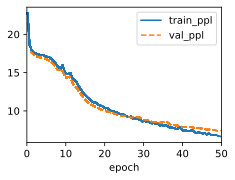

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## 9.2.3 [**Concise Implementation**]

High level한 API를 이용하면 간단하면서 빠르게 학습시킬 수 있다. 


In [ ]:
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

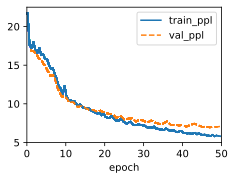

In [ ]:
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [ ]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has is the time the tim'

LSTM은 잠재변수를 이용한 자기회귀 모델의 원형과도 같다. multiple layers, residual connections, 다양한 유형의 정규화 등과 같은 수많은 변형이 수년간 제기되어 왔다. 그러나 LSTM이나 GRU와 같은 시퀀스 모델을 훈련시키는 것은 시퀀스의 긴 범위 종속으로 인해 상당한 비용이 들기도 한다. 경우에 따라 transformer와 같은 대체 모델을 사용하는 것을 뒷부분에서 만나볼 수 있을 것이다.


## Summary

* LSTMs have three types of gates: input gates, forget gates, and output gates that control the flow of information.
* The hidden layer output of LSTM includes the hidden state and the memory cell. Only the hidden state is passed into the output layer. The memory cell is entirely internal.
* LSTMs can alleviate vanishing and exploding gradients.


# 9.3.Deep Recurrent Neural Networks

여태 우리는 단층의 단방향 은닉 레이어만 있는 RNN에 대해 논의하였다. 이 안에서 은닉 상태(H)와 관측치(X)가 상호작용하는 구체적인 함수의 형태는 다소 임의적이다. 서로 다른 유형의 상호 작용을 모델링할 수 있는 충분한 유연성이 있는한 큰 문제가 되지 않겠지만 단층의 레이어만 있는 경우 상당히 어려운 문제가 될 수 있다. 선형모델(fully connected model)에서는 여러 층을 쌓음으로써 비선형성을 추가하고 이런 문제를 해결했는데 RNN에서는 비선형성을 추가하는 방법과 위치를 결정해야하므로 조금 더 까다로울 수 있다.

실제로, 여러 층의 RNN을 서로 겹쳐 쌓을 수 있는데 이러한 구조는 간단한 레이어들의 조합으로 인해 유연한 메커니즘을 만들어내게 된다. 특히 데이터는 다른 층의 레벨에서 관련이 생길 수 있다. 예를 들어 금융 시장 상황(전반적인 약세 혹은 전반적인 강세)에 대해 높은 수준의 데이터를 계속 유지하기 원할 수 있지만, 낮은 수준에서는 단기적인 시간적 역학만 기록할 수도 있다.

다음 그림은 L개의 숨겨진 레이어가 있는 심층 RNN의 구조를 나타낸다. 각 레이어의 은닉 상태는 현재 레이어의 다음 단계와 다음 레이어의 현재 시간 단계 모두에 연속적으로 전달된다.

![Architecture of a deep RNN.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/deep-rnn.svg?raw=1)



## 9.3.1. Functional Dependencies

매 시점 t마다 n개의 미니배치를 갖는 input
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$ (number of examples: $n$, number of inputs in each example: $d$)가 있다 하자. <br>
동시에 $l^\mathrm{th}$ hidden layer  ($l=1,\ldots,L$)의 은닉상태를 $\mathbf{H}_t^{(l)}  \in \mathbb{R}^{n \times h}$ (number of hidden units: $h$)라고 하며 output layer의 변수를 $\mathbf{O}_t \in \mathbb{R}^{n \times q}$ (number of outputs: $q$)라고 하자. 

$l$번째 hidden layer의 은닉상태 $H_t$는 다음과 같이 계산된다.<br>

$$\mathbf{H}_t^{(l)} = \phi_l(\mathbf{H}_t^{(l-1)} \mathbf{W}_{xh}^{(l)} + \mathbf{H}_{t-1}^{(l)} \mathbf{W}_{hh}^{(l)}  + \mathbf{b}_h^{(l)}),$$

$\mathbf{H}_t^{(0)} = \mathbf{X}_t$<br>
$\phi_l$ : activation function

(weights)<br>
$\mathbf{W}_{xh}^{(l)} \in \mathbb{R}^{h \times h}$ <br>
$\mathbf{W}_{hh}^{(l)} \in \mathbb{R}^{h \times h}$,<br>
(bias)<br>
$\mathbf{b}_h^{(l)} \in \mathbb{R}^{1 \times h}$<br>
=> model parameters of $l^\mathrm{th}$ hidden layer

마지막 계층의 output은 오직 L번 째 hidden layer의 은닉 상태로만 계산된다.


$$\mathbf{O}_t = \mathbf{H}_t^{(L)} \mathbf{W}_{hq} + \mathbf{b}_q,$$

(weights)<br>
$\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$
(bias)<br>
$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$<br>
=> model parameters of the output layer

마치 다층퍼셉트론 구조처럼 hidden layer의 수 L과 은닉 유닛의 수(차원) h는 하이퍼파라미터로서 사람에 의해 조정된다. 은닉상태의 계산을 simple RNN 대신 GRU나 LSTM으로 대체함으로써 더 나은 심층 RNN을 쉽게 얻을 수 있다.

## 9.3.2. Implementation from Scratch

심층 RNN을 처음부터 구현하기 위해, 각 계층을 학습 가능한 매개변수를 가진 RNNScratch로 처리할 수 있다.

In [ ]:
class StackedRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnns = nn.Sequential(
            *[d2l.RNNScratch(num_inputs if i==0 else num_hiddens, num_hiddens, sigma) for i in range(num_layers)]
            )

다음과 같이 forward propagation을 정의해준다.


In [ ]:
@d2l.add_to_class(StackedRNNScratch)
def forward(self, inputs, Hs=None):

    outputs = inputs
    if Hs is None: 
        Hs = [None] * len(inputs)

    for i in range(self.num_layers):
        outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
        
    return outputs, Hs

심층 RNN 구조를 마찬가지로 *The Time Machine* dataset에 대해 학습시킨다. 간단하게 살펴보고자 layer의 개수는 2개로 한다.


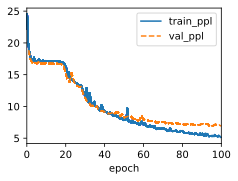

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn_block = StackedRNNScratch(num_inputs=len(data.vocab),
                              num_hiddens=32, num_layers=2)
model = d2l.RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## 9.3.3. Concise Implementation

마찬가지로 심층 RNN을 구현하는 것 역시 High-level한 API에서 쉽게 사용할 수 있다.

In [ ]:
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, num_layers,
                          dropout=dropout)

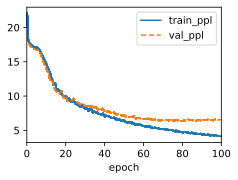

In [ ]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)

In [ ]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has domensions the time'

## Summary

* In deep RNNs, the hidden state information is passed to the next time step of the current layer and the current time step of the next layer.
* There exist many different flavors of deep RNNs, such as LSTMs, GRUs, or vanilla RNNs. Conveniently these models are all available as parts of the high-level APIs of deep learning frameworks.
* Initialization of models requires care. Overall, deep RNNs require considerable amount of work (such as learning rate and clipping) to ensure proper convergence.


# 9.4. Bidirectional Recurrent Neural Networks

시퀀스 학습에서 지금까지는 다음 출력에 대한 예측을 모델링하는 것을 목표로 하였다. 이러한 상황이 일반적인 시나리오이기는 하지만 유일한 시나리오는 아니다. 가령 예를 들면 다음과 같은 상황에서 빈칸을 채우는 것을 생각해볼 수 있다.

* I am ___.
* I am ___ hungry.
* I am ___ hungry, and I can eat half a pig.

이용 가능한 정보의 양에 따라 "happy", "not", 혹은 "very" 등의 단어를 채울 수 있을 것이다. 구문의 끝 부분은 어떤 단어를 선택해야 하는지에 대한 중요한 정보를 분명히 전달한다. 이를 활용할 수 없는 시퀀스 모델은 관련 작업에서 성능이 떨어진다. 예를 들어 Green이 Mr.Green이라는 사람을 지칭하는지 아니면 초록색을 의미하는지를 파악하는 것과 같은 작업을 잘 수행하기 위해서는 더 긴 범위의 맥락 역시 중요하다. 문제를 잘 해결하기 위한 영감을 얻기 위해 확률론적 그래픽 모델로 우회해 보도록 한다.




## 9.4.1.  Dynamic Programming in Hidden Markov Models

This subsection serves to illustrate the dynamic programming problem. The specific technical details do not matter for understanding the deep learning models
but they help in motivating why one might use deep learning and why one might pick specific architectures.

If we want to solve the problem using probabilistic graphical models we could for instance design a latent variable model as follows.
At any time step $t$,
we assume that there exists some latent variable $h_t$ that governs our observed emission $x_t$ via $P(x_t \mid h_t)$.
Moreover, any transition $h_t \to h_{t+1}$ is given by some state transition probability $P(h_{t+1} \mid h_{t})$. This probabilistic graphical model is then a *hidden Markov model*  as in :numref:`fig_hmm`.

![A hidden Markov model.](http://d2l.ai/_images/hmm.svg)
:label:`fig_hmm`

Thus,
for a sequence of $T$ observations we have the following joint probability distribution over the observed and hidden states:

$$P(x_1, \ldots, x_T, h_1, \ldots, h_T) = \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t), \text{ where } P(h_1 \mid h_0) = P(h_1).$$
:eqlabel:`eq_hmm_jointP`


Now assume that we observe all $x_i$ with the exception of some $x_j$ and it is our goal to compute $P(x_j \mid x_{-j})$, where $x_{-j} = (x_1, \ldots, x_{j-1}, x_{j+1}, \ldots, x_{T})$.
Since there is no latent variable
in $P(x_j \mid x_{-j})$,
we consider summing over
all the possible combinations of choices for $h_1, \ldots, h_T$.
In case any $h_i$ can take on $k$ distinct values (a finite number of states), this means that we need to sum over $k^T$ terms---usually mission impossible! Fortunately there is an elegant solution for this: *dynamic programming*.

To see how it works,
consider summing over latent variables
$h_1, \ldots, h_T$ in turn.
According to :eqref:`eq_hmm_jointP`,
this yields:

$$\begin{aligned}
    &P(x_1, \ldots, x_T) \\
    =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_2, \ldots, h_T} \underbrace{\left[\sum_{h_1} P(h_1) P(x_1 \mid h_1) P(h_2 \mid h_1)\right]}_{\pi_2(h_2) \stackrel{\mathrm{def}}{=}}
    P(x_2 \mid h_2) \prod_{t=3}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_3, \ldots, h_T} \underbrace{\left[\sum_{h_2} \pi_2(h_2) P(x_2 \mid h_2) P(h_3 \mid h_2)\right]}_{\pi_3(h_3)\stackrel{\mathrm{def}}{=}}
    P(x_3 \mid h_3) \prod_{t=4}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t)\\
    =& \dots \\
    =& \sum_{h_T} \pi_T(h_T) P(x_T \mid h_T).
\end{aligned}$$

In general we have the *forward recursion* as

$$\pi_{t+1}(h_{t+1}) = \sum_{h_t} \pi_t(h_t) P(x_t \mid h_t) P(h_{t+1} \mid h_t).$$

The recursion is initialized as $\pi_1(h_1) = P(h_1)$. In abstract terms this can be written as $\pi_{t+1} = f(\pi_t, x_t)$, where $f$ is some learnable function. This looks very much like the update equation in the latent variable models we discussed so far in the context of RNNs!

Entirely analogously to the forward recursion,
we can also
sum over the same set of latent variables with a backward recursion. This yields:

$$\begin{aligned}
    & P(x_1, \ldots, x_T) \\
     =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot P(h_T \mid h_{T-1}) P(x_T \mid h_T) \\
    =& \sum_{h_1, \ldots, h_{T-1}} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_T} P(h_T \mid h_{T-1}) P(x_T \mid h_T)\right]}_{\rho_{T-1}(h_{T-1})\stackrel{\mathrm{def}}{=}} \\
    =& \sum_{h_1, \ldots, h_{T-2}} \prod_{t=1}^{T-2} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_{T-1}} P(h_{T-1} \mid h_{T-2}) P(x_{T-1} \mid h_{T-1}) \rho_{T-1}(h_{T-1}) \right]}_{\rho_{T-2}(h_{T-2})\stackrel{\mathrm{def}}{=}} \\
    =& \ldots \\
    =& \sum_{h_1} P(h_1) P(x_1 \mid h_1)\rho_{1}(h_{1}).
\end{aligned}$$


We can thus write the *backward recursion* as

$$\rho_{t-1}(h_{t-1})= \sum_{h_{t}} P(h_{t} \mid h_{t-1}) P(x_{t} \mid h_{t}) \rho_{t}(h_{t}),$$

with initialization $\rho_T(h_T) = 1$.
Both the forward and backward recursions allow us to sum over $T$ latent variables in $\mathcal{O}(kT)$ (linear) time over all values of $(h_1, \ldots, h_T)$ rather than in exponential time.
This is one of the great benefits of the probabilistic inference with graphical models.
It is
also a very special instance of
a general message passing algorithm :cite:`Aji.McEliece.2000`.
Combining both forward and backward recursions, we are able to compute

$$P(x_j \mid x_{-j}) \propto \sum_{h_j} \pi_j(h_j) \rho_j(h_j) P(x_j \mid h_j).$$

Note that in abstract terms the backward recursion can be written as $\rho_{t-1} = g(\rho_t, x_t)$, where $g$ is a learnable function. Again, this looks very much like an update equation, just running backwards unlike what we have seen so far in RNNs. Indeed, hidden Markov models benefit from knowing future data when it is available. Signal processing scientists distinguish between the two cases of knowing and not knowing future observations as interpolation v.s. extrapolation.
See the introductory chapter of the book on sequential Monte Carlo algorithms for more details :cite:`Doucet.De-Freitas.Gordon.2001`.




## 9.4.2. Bidirectional Model

hidden Markov model에서와 유사한 예측 능력을 제공하는 메커니즘을 RNN에서 사용하려면 지금까지 살펴본 RNN 설계를 수정해야한다. 첫 번째 토큰에서부터 시작해 forward 모드에서만 RNN을 실행하는 대신, 마지막 토큰에서부터 뒤에서 앞으로 실행되는 다른 RNN을 시작한다. 이런 양방향 RNN은 정보를 역방향으로 전달하는 hidden layer를 추가하여 이러한 정보를 보다 유연하게 처리한다.

![Architecture of a bidirectional RNN.](http://d2l.ai/_images/birnn.svg)





### 9.4.2.1. Definition

Bidirectional RNNs은 [Schuster.Paliwal.1997]에 의해 처음 소개되었다. 조금더 디테일하고 다양한 논의들을 보고자 한다면 [Graves.Schmidhuber.2005]를 참고하면 된다. 구체적인 네트워크 모양을 살펴보면 다음과 같다.


$\mathbf{X}_t \in \mathbb{R}^{n \times d}$ (number of examples: $n$, number of inputs in each example: $d$) : mini batch input<br>
$\overrightarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$ : forward hidden state<br>
$\overleftarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$ : backward hidden state<br>
(h는 hidden unit의 수)<br>

forward와 backward의 은닉 상태의 업데이트는 다음과 같다.

$$
\begin{aligned}
\overrightarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(f)} + \overrightarrow{\mathbf{H}}_{t-1} \mathbf{W}_{hh}^{(f)}  + \mathbf{b}_h^{(f)}),\\
\overleftarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(b)} + \overleftarrow{\mathbf{H}}_{t+1} \mathbf{W}_{hh}^{(b)}  + \mathbf{b}_h^{(b)}),
\end{aligned}
$$

(weights)
$\mathbf{W}_{xh}^{(f)} \in \mathbb{R}^{d \times h}$<br>
$\mathbf{W}_{hh}^{(f)} \in \mathbb{R}^{h \times h}$<br>
$\mathbf{W}_{xh}^{(b)} \in \mathbb{R}^{d \times h}$<br>
$\mathbf{W}_{hh}^{(b)} \in \mathbb{R}^{ \times h}$ <br>

(bias)<br>
$\mathbf{b}_h^{(f)} \in \mathbb{R}^{1 \times h}$<br>
$\mathbf{b}_h^{(b)} \in \mathbb{R}^{1 \times h}$ <br>
=>model parameters.

이어서 forwar와 backward에 대한 hidden states $\overrightarrow{\mathbf{H}}_t$,$\overleftarrow{\mathbf{H}}_t$를 concat하여 hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times 2h}$를 얻고 이를 출력계층으로 전달한다. 만일 여러 은닉층들로 이뤄진 deep bidirectional RNNs구조라면 다음 레이어에 대한 입력으로써 사용한다. 마지막으로 output layer의 출력 $\mathbf{O}_t \in \mathbb{R}^{n \times q}$ (number of outputs: $q$)을 얻기 위해 다음과 같은 과정을 과정을 수행한다.

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

(weights)<br>
$\mathbf{W}_{hq} \in \mathbb{R}^{2h \times q}$<br>

(bias)<br>
$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$ <br>
=> output layer의 model parameters 

여기서는 똑같이 h로 설정했으나 두 방향이 다른 개수의 은닉 유닛을 가질 수도 있다.


### 9.4.2.2. Computational Cost and Applications

bidirectional RNN의 주요 특징 중 하나는 시퀀스의 양쪽 끝의 정보가 출력을 추정하는데 사용된다는 것이다. 즉 현재 관측치를 예측하기 위해 미래 및 과거 관측치의 정보를 모두 사용한다. 결국, 우리는 다음 토큰을 예측할 때 다음 토큰을 알 수 있는 능력을 학습시키지 못했다. 단순히 bidirectional RNN을 사용한다면 좋은 정확도를 얻지 못할 것이다. 훈련 중에는 현재를 추정하기 위한 과거와 미래 데이터 셋을 가지고 있지만 테스트시에는 과거 데이터만 가지고 있기 때문에 정확도가 떨어진다.

forwardpropagation이 양방향 계층(layer)에서 forward 방향과 backward 방향 재귀를 모두 필요로 하고 backpropagtion은 forwardpropagation의 결과에 의존하기 때문에 gradient는 매우 긴 종속성을 가지고 있게 되고 이는 bidirectional RNN이 매우 느린 결과로 이어진다.

실제로 bidirectional RNN은 누락된 단어 채우기, 토큰 주석 달기, 시퀀스 처리 파이프라인으로써의 시퀀스 인코딩(예: 기계 번역)하는 것과 같은 좁은 분야에만 한정적으로 사용된다.

## 9.4.3 (**Training a Bidirectional RNN for a Wrong Application**)

아래 보듯이 bidirectional RNN이 과거 및 미래 데이터를 사용한다는 사실을 무시하고 단순히 언어 모델에 적용한다면, 미래의 토큰을 예측하는 능력이 매우 별로인 것을 확인할 수 있다.


### 9.4.3.1 Implementation from Scratch

사전에 사용했던 RNNScratch를 사용해 bidirectional 구조를 쉽게 짤 수 있다.

In [ ]:
class BiRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.f_rnn = d2l.RNNScratch(num_inputs, num_hiddens, sigma)
        self.b_rnn = d2l.RNNScratch(num_inputs, num_hiddens, sigma)
        self.num_hiddens *= 2  # The output dimension will be doubled

forward와 backward의 상태는 각각 따로 업데이트되지만 이 두 RNN의 output은 concat된다.

In [ ]:
@d2l.add_to_class(BiRNNScratch)
def forward(self, inputs, Hs=None):
    f_H, b_H = Hs if Hs is not None else (None, None)
    f_outputs, f_H = self.f_rnn(inputs, f_H)
    b_outputs, b_H = self.b_rnn(reversed(inputs), b_H)
    outputs = [torch.cat((f, b), -1) for f, b in zip(f_outputs, b_outputs)]
    return outputs, (f_H, b_H)

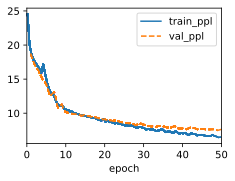

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
birnn = BiRNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(birnn, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

### 9.4.3.2 Concise Implementation

마찬가지로 High-level API가 제공되므로 쉽게 사용해 볼 수 있다.


In [ ]:
class BiGRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, bidirectional=True)
        self.num_hiddens *= 2

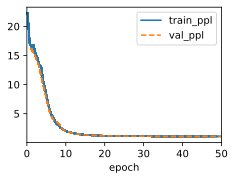

In [ ]:
gru = BiGRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)

In [ ]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it hasasasasasasasasasasas'

이미 설명되었듯 만족스럽지 못한 결과가 나온다. 이 bidirectional RNN의 보다 효과적인 사용에 대한 논의는 15장을 참고하면 된다.

## Summary

* In bidirectional RNNs, the hidden state for each time step is simultaneously determined by the data prior to and after the current time step.
* Bidirectional RNNs bear a striking resemblance with the forward-backward algorithm in probabilistic graphical models.
* Bidirectional RNNs are mostly useful for sequence encoding and the estimation of observations given bidirectional context.
* Bidirectional RNNs are very costly to train due to long gradient chains.


[Discussions](https://discuss.d2l.ai/t/1056)
